In [1]:
import tensorflow as tf
import segmentation_models as sm
import cv2
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import keras 
from tensorflow.keras.utils import normalize
from tensorflow.keras.metrics import MeanIoU
from skimage.transform import resize

Segmentation Models: using `keras` framework.


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
classes_dict = {"Not Tumor": 0, "Meningioma": 1, "Glioma": 2, "Pituitary": 3}

In [4]:
size = 128
test_DF = pd.read_pickle(r"../../../Datasets/Dataset_A/aug_test_DF_{}.pkl".format(size))

def normalize(img):
    plt.imsave('DR.png', img, cmap='gray')
    return cv2.imread('DR.png')[:, :, 0]

test_DF["Images"] = test_DF["Images"].apply(normalize)

for index, row in test_DF.iterrows():
    row["Tumor Mask"] = row["Tumor Mask"] * classes_dict[row["Labels"]]
    

y_test = test_DF["Tumor Mask"].tolist()
X_test = test_DF['Images'].tolist()
y_test = np.array(y_test).reshape(-1, size, size)
X_test = np.array(X_test).reshape(-1, size, size)

y_test = np.expand_dims(y_test, axis=3)
X_test = np.expand_dims(X_test, axis=3)
X_test = X_test/255


print("X_test shape:", X_test.shape)
print("y_test shape:",y_test.shape)

print("\nTotal Data: ", (len(y_test)+len(X_test)))

X_test shape: (1840, 128, 128, 1)
y_test shape: (1840, 128, 128, 1)

Total Data:  3680


In [5]:
class_weights = np.load("class_weights.npy")
dice_loss = sm.losses.DiceLoss(class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


metrics_obj = {"dice_loss_plus_1focal_loss": total_loss,
               "iou_score": sm.metrics.IOUScore(threshold=0.5),
              "f1-score": sm.metrics.FScore(threshold=0.5)}


In [6]:
exp_number = 3
model = tf.keras.models.load_model(r".\experiments\exp#{}\weights\First_Mulit_UNet.h5".format(exp_number),  custom_objects=metrics_obj)
metrics = pd.read_pickle(r".\experiments\exp#{}\results\metrics.pkl".format(exp_number))

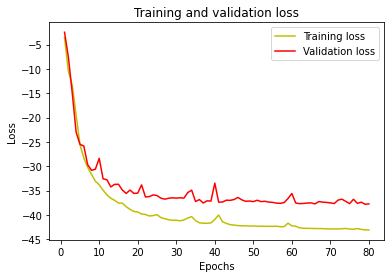

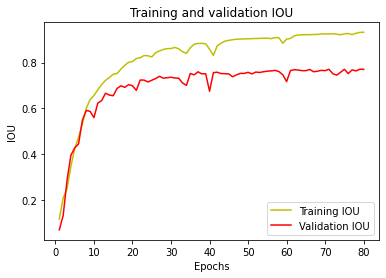

In [7]:
loss = metrics['loss']
val_loss = metrics['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = metrics['iou_score']
val_acc = metrics['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [8]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

##################################################

#Using built in keras function
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


#To calculate I0U for each class...
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[1,0]+ values[2,0]+ values[3,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[0,1]+ values[2,1]+ values[3,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[0,2]+ values[1,2]+ values[3,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[0,3]+ values[1,3]+ values[2,3])

print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)

Mean IoU = 0.77823335
IoU for class1 is:  0.98727626
IoU for class2 is:  0.8304724
IoU for class3 is:  0.53874844
IoU for class4 is:  0.7564363


In [9]:
def prob_class(predicted_img, class_dic):
    rev_classes_dict = dict([(value, key) for key, value in class_dic.items()])
    result = ""
    if len(np.unique(predicted_img)) == 1:
        result = "(No Tumor)"
    else:
        for cls in np.unique(predicted_img):
            if cls != 0:
                prob = (predicted_img == cls).sum() / (0 != predicted_img).sum() 
                result += "({} {}%) ".format(rev_classes_dict[cls], str( round(prob*100, 2) ))

    return result

def get_IoU(ground_truth_img, predicted_img):
    intersection = np.logical_and(ground_truth_img, predicted_img)
    union = np.logical_or(ground_truth_img, predicted_img)
    return round(np.sum(intersection) / np.sum(union), 2)

def pred_class(mask):
    background = (mask == classes_dict["Not Tumor"]).sum() 
    meningioma = (mask == classes_dict["Meningioma"]).sum() 
    glioma = (mask == classes_dict["Glioma"]).sum() 
    pituitary = (mask == classes_dict["Pituitary"]).sum()
    
    return np.array([background, meningioma, glioma, pituitary])

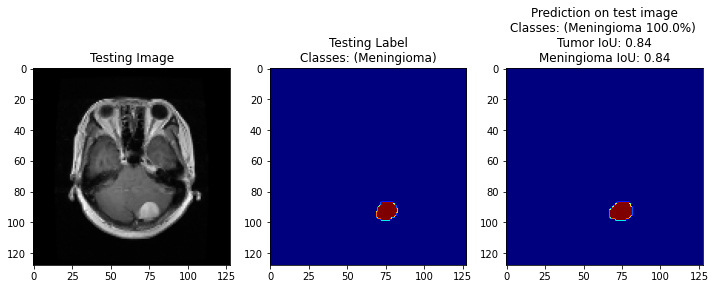

In [10]:
import random
test_img_number = random.randint(0, len(X_test))
rev_classes_dict = dict([(value, key) for key, value in classes_dict.items()])



test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


ground_truth_label = np.unique(ground_truth)[1]


tumor_IoU = get_IoU(ground_truth[:, :, 0], predicted_img)
tumor_type_IoU = get_IoU(ground_truth[:, :, 0], (predicted_img == ground_truth_label))




plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')

plt.subplot(232)
plt.title('Testing Label\nClasses: ({})'.format(rev_classes_dict[ground_truth_label]))
plt.imshow(ground_truth[:,:,0], cmap='jet')

plt.subplot(233)
plt.title('Prediction on test image\nClasses: {}\nTumor IoU: {}\n{} IoU: {}'.format(prob_class(predicted_img, classes_dict), tumor_IoU, rev_classes_dict[ground_truth_label], tumor_type_IoU))
plt.imshow(predicted_img, cmap='jet')
plt.show()

In [11]:
def eval(model, X_test, y_test, threshold=0.5):
    good_iou = 0
    total_num = len(X_test)
    for i in range(total_num):
        ground_truth_label = np.unique(y_test[i, :, :, 0])[1]
        mask = y_test[i, :, :, 0]
        
        img = np.expand_dims(X_test[i, :, :, :], 0)
        prediction = (model.predict(img))
        predicted_img = np.argmax(prediction, axis=3)[0,:,:]
        if get_IoU((predicted_img == ground_truth_label), mask) >= 0.5:
            good_iou += 1
    return good_iou / total_num


def accuracy(model, X_test, y_test, threshold=0.5):
    correct_class = 0
    total_num = len(X_test)
    
    for i in range(total_num):
        mask = y_test[i, :, :, 0]    
        img = np.expand_dims(X_test[i, :, :, :], 0)
        prediction = (model.predict(img))
        predicted_img = np.argmax(prediction, axis=3)[0,:,:]
        
        ground_truth_label = np.unique(mask)[1]
        predicted_lable = np.argmax(pred_class(predicted_img)[1:]) + 1
        
        if predicted_lable == ground_truth_label:
            correct_class += 1
            
    return correct_class / total_num

In [12]:
accuracy(model, X_test, y_test)

0.9527173913043478

In [13]:
eval(model, X_test, y_test)

0.7614130434782609

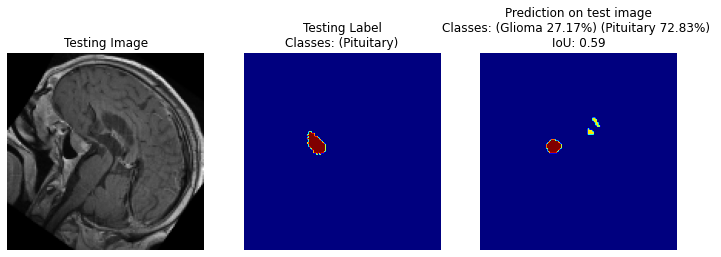

In [268]:
import random
test_img_number = random.randint(0, len(X_test))
rev_classes_dict = dict([(value, key) for key, value in classes_dict.items()])



test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


ground_truth_label = np.unique(ground_truth)[1]


tumor_IoU = get_IoU(ground_truth[:, :, 0], predicted_img)
tumor_type_IoU = get_IoU(ground_truth[:, :, 0], (predicted_img == ground_truth_label))




plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.axis("off")

plt.subplot(232)
plt.title('Testing Label\nClasses: ({})'.format(rev_classes_dict[ground_truth_label]))
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.axis("off")

plt.subplot(233)
plt.title('Prediction on test image\nClasses: {}\nIoU: {}'.format(prob_class(predicted_img, classes_dict), tumor_type_IoU))
plt.imshow(predicted_img, cmap='jet')
plt.axis("off")
plt.show()